# Sentinel-2 snow cover classification in Python (Tutorial with excercise)

Author: Andreas Mayr

Date: 27 April 2023

This Notebook shows how to implement a simple snow classification workflow on a Sentinel-2 (S-2) satellite image time series.

For a small test site in the Alps (Obergurgl, Austria) an **S-2 Normalized Difference Snow Index (NDSI) time series** is downloaded from the Google Earth Engine (GEE) and **classified per-scene** into snow-covered and snow-free areas, using the widely used NDSI threshold of 0.4. The results of this simple **rule-based classification** are analysed and visualized regarding the **duration of snow cover** (months) per pixel and percentage of **snow-covered area** within the area-of-interest (AOI) per month.

For Google Earth Engine (GEE) and xarrays raster time series processing we use the [geemap](https://geemap.org/), [wxee](https://wxee.readthedocs.io/en/latest/index.html) and [eemont](https://eemont.readthedocs.io/) packages.

This is an extended version of the notebook including a suggestion to solve the related ETRAINEE excercise.

## Set up the environment

Use the `m1_etrainee` environment containing the required packages, or create it now to install the packages. geemap seems to need python < 3.10. As the packages we need depend on a lot of other packages, solving the environment with conda can take a long time. So let's try [mamba](https://mamba.readthedocs.io/en/latest/index.html). In my case, this was quite fast.

```
conda create -n m1_etrainee python=3.9
conda activate m1_etrainee
conda install mamba
mamba install ipykernel earthengine-api eemont geemap wxee pygis geopandas seaborn hvplot scikit-learn datashader stackstac xarrayutils xmovie
```

Some of the packages are not needed here but in related Notebooks. Now we might have to re-start or refresh VSCode to actually be able to select the environment as a kernel.

Import packages:

In [3]:
import ee, eemont, geemap, wxee

Authenticate and initialize Google Earth Engine:

In [4]:
try:
        wxee.Initialize()
except Exception as e:          # If initialize does not work, you probably have to authenticate first
        ee.Authenticate()
        wxee.Initialize()

## Construct an area-of-interest (AOI)

We want a area around Obergurgl (Tyrol, Austria) as our area-of-interest (AOI).

A query is a string representing a place that is geocoded in order to get its Bounding Box coordinates.
In eemont, a Bounding Box (polygon) can be constructed from a query using the geopy package.
An ee.Geometry.BBox can be constructed using the ee.Geometry.BBoxFromQuery constructor (extended through eemont).

In [5]:
AOI = ee.Geometry.BBoxFromQuery("Obergurgl, Austria", user_agent = "RS_course")

The user_agent argument must be specified: This is a string describing the name of the app that is using a geocoding service (you can use here your GEE username).

The geemap package offers a rich interactive mapping functionality.

In [6]:
Map = geemap.Map()
Map.addLayer(AOI,{'color':'blue'},'Nominatim')  # Open Street Map geocoding service
Map.centerObject(AOI,10)
Map

Map(center=[46.87037509744985, 11.02749840000902], controls=(WidgetControl(options=['position', 'transparent_b…

Retrieve an image collection from GEE, preprocess it and calculate the NDSI.

In [7]:
S2 = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterDate("2022-01-01","2022-06-30") \
    .filterBounds(AOI) \
    .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 30) \
    .preprocess() \
    .spectralIndices("NDSI") \
    .select("NDSI")

We have filtered by a date range and by bounds, i.e. queried imagery for the year 2022 and for our AOI.
The eemont ``preprocess()`` method automatically masks clouds and shadows and scales and offsets the image or image collection. The eemont ``spectralIndices()`` method can calculate any index from the [Awesome Spectral Indices](https://awesome-ee-spectral-indices.readthedocs.io/en/latest/) library. For snow classification we will only use the NDSI, no original bands.

## Aggregate and download time series

Create a wxee TimeSeries object to enable xarray operations, such as temporal aggregations.

In [8]:
S2_ts = S2.wx.to_time_series()

First, get some info about our time series.

In [9]:
S2_ts.describe()

COPERNICUS/S2_SR
	Images: 68
	Start date: 2022-01-01 10:27:43 UTC
	End date: 2022-06-27 10:18:12 UTC
	Mean interval: 2.64 days


And plot the timeline to see how the (low-cloudiness) observations are distributed over the observation period.

In [10]:
S2_ts.wx.to_time_series().timeline()

Perform a temporal aggregation (calculate monthly medians) of our time series in the GEE.

In [11]:
S2_monthly_ts= S2_ts.aggregate_time(frequency="month", reducer=ee.Reducer.median())

Now use wxee to get the result of the time series aggregation to an xarray Dataset (downloading the aggregated rasters). You could also download multiple images as GeoTIFFs. Wxee, however, is not designed to download larger areas and high resolution - in such cases consider downloading to a Google Drive using ee or to a local drive using geemap. *In our case 12 months with 20 m resolution throw a GEE memory error ("User memory exceeded"). Therefore, we split the request and download simply into two parts with 6 months each.*

Either define a path where a NetCDF file will be written to, or load the Dataset into memory.
You can set the scale parameter to control the resolution. See the [documentation](https://wxee.readthedocs.io/en/latest/generated/wxee.collection.ImageCollection.to_xarray.html) for more options.

The requests and downloads may take some minutes.

In [12]:
S2_ds_1 = S2_monthly_ts.wx.to_xarray(region = AOI, crs='EPSG:25832', scale=20)

Requesting data:   0%|          | 0/6 [00:00<?, ?it/s]

We repeat the data query and download for the second part of the year.

In [13]:
S2 = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterDate("2022-07-01","2022-12-31") \
    .filterBounds(AOI) \
    .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 30) \
    .preprocess() \
    .spectralIndices("NDSI") \
    .select("NDSI")                                                                     # Query S2 NDSI from GEE
S2_ts = S2.wx.to_time_series()                                                          # Build wxee time series object
S2_monthly_ts= S2_ts.aggregate_time(frequency="month", reducer=ee.Reducer.median())     # Reduce NDSI to monthly median
S2_ds_2 = S2_monthly_ts.wx.to_xarray(region = AOI, crs='EPSG:25832', scale=20)          # Download monthly NDSI

Requesting data:   0%|          | 0/6 [00:00<?, ?it/s]

Concatenate the two xarray Datasets (six months of monthly NDSI each) along the time dimension and check the final Dataset we obtained.

In [14]:
import xarray as xr
S2_ds = xr.concat([S2_ds_1, S2_ds_2], dim='time')
S2_ds

<xarray.Dataset>
Dimensions:  (time: 12, y: 227, x: 159)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01T10:27:57 ... 2022-12-07T10:27:56
  * y        (y) float64 5.195e+06 5.195e+06 5.195e+06 ... 5.191e+06 5.19e+06
  * x        (x) float64 6.529e+05 6.53e+05 6.53e+05 ... 6.561e+05 6.561e+05
Data variables:
    NDSI     (time, y, x) float64 0.8335 0.8201 0.7924 ... 0.7246 0.7509 0.6929
Attributes:
    transform:               (20.0, 0.0, 652920.0, 0.0, -20.0, 5195020.0)
    crs:                     +init=epsg:25832
    res:                     (20.0, 20.0)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

Note that we have only downloaded the monthly medians of the NDSI, no other bands.

## Show NDSI maps

Plot the monthly NDSI maps using wxee/xarray built-in plotting functions:

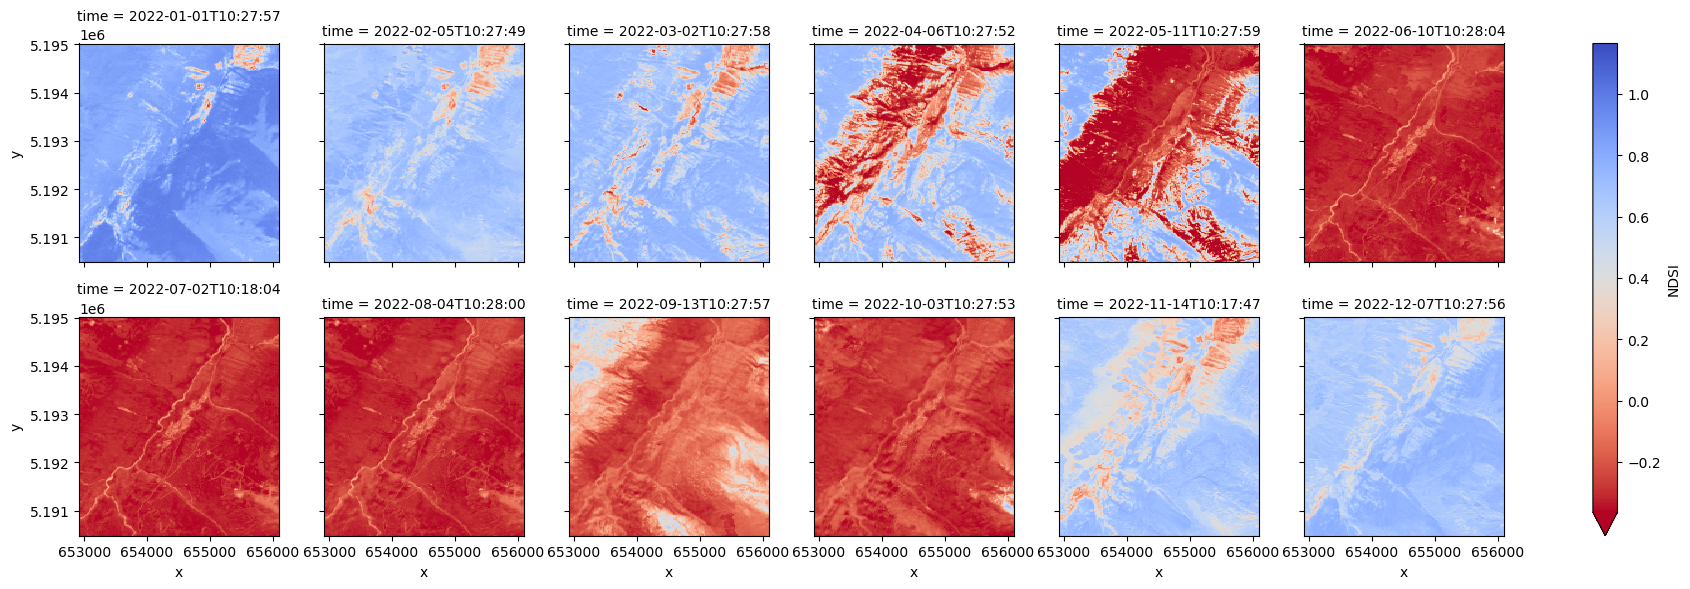

In [15]:
S2_ds.NDSI.plot(col="time", col_wrap=6, cmap='coolwarm_r', center=0.4, aspect=1, robust=True)

## Snow classification for each month

We can use the NDSI to map binary snow cover simply by thresholding the NDSI, e.g. with the widely used threshold 0.4 (which we also used to center the colormap in the plot above). This results in a time series of monthly snow/no-snow maps (encoded as 1/0).

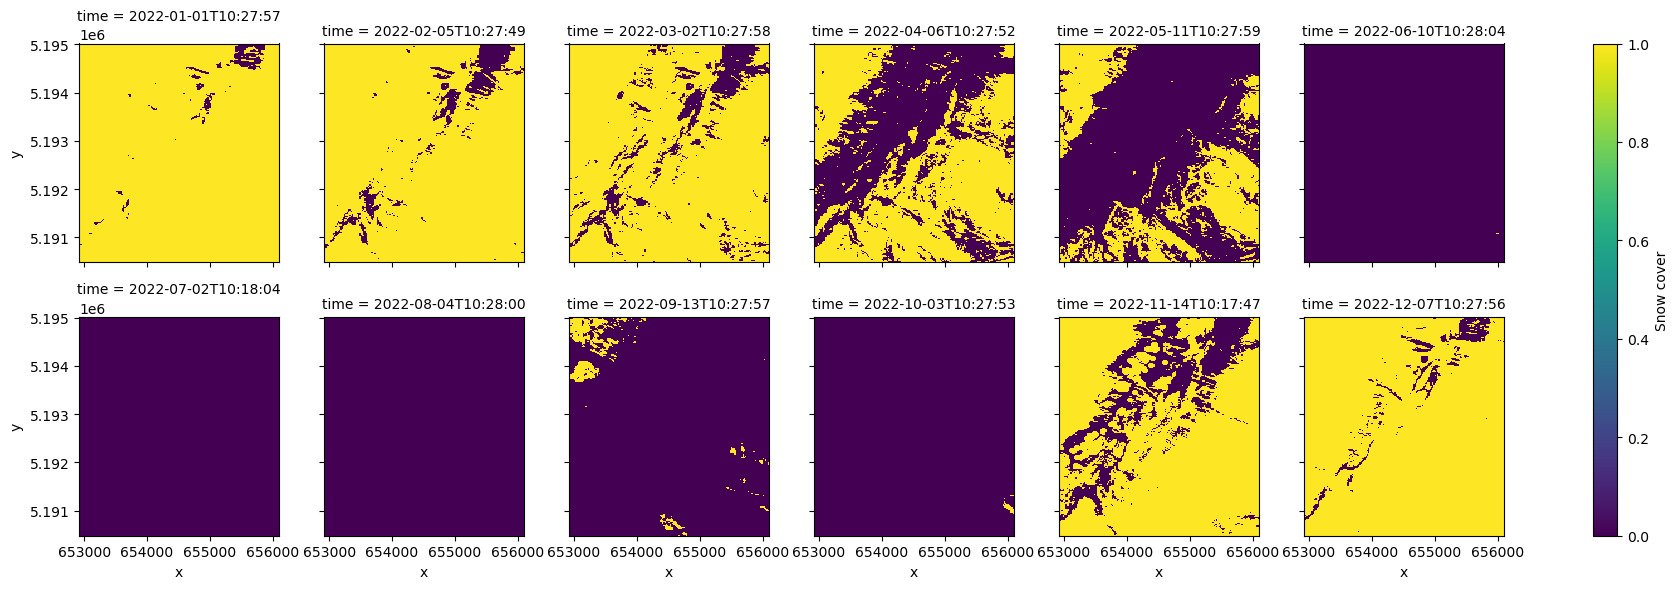

In [16]:
import xarray as xr
snow = xr.where(S2_ds.NDSI>0.4, 1, 0)
snow.attrs = S2_ds.attrs                                                # Copy the attributes of the S2 Dataset (CRS, spatial res., ...)
snow.plot(col='time', col_wrap=6, cbar_kwargs={'label': 'Snow cover'})

Let's take this time series of snow/no-snow maps to quantify the percentage of our area-of-interest that is snow covered for each month. 

In [17]:
import numpy as np
snow_percentage = np.nanmean(snow.values, axis=(1,2))*100

... and plot this.

Text(0, 0.5, 'Snow covered area [%]')

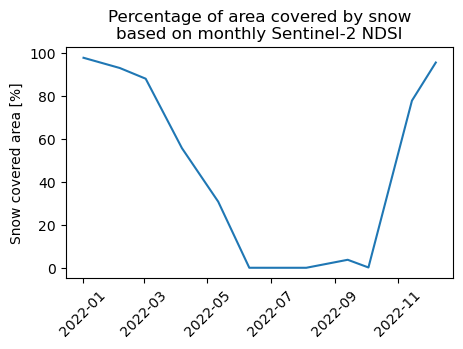

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(snow.time, snow_percentage)
plt.title("Percentage of area covered by snow\nbased on monthly Sentinel-2 NDSI")
plt.xticks(rotation=45)
plt.ylabel("Snow covered area [%]")

## Snow cover duration per pixel

Finally calculate how many months every pixel is snow covered.

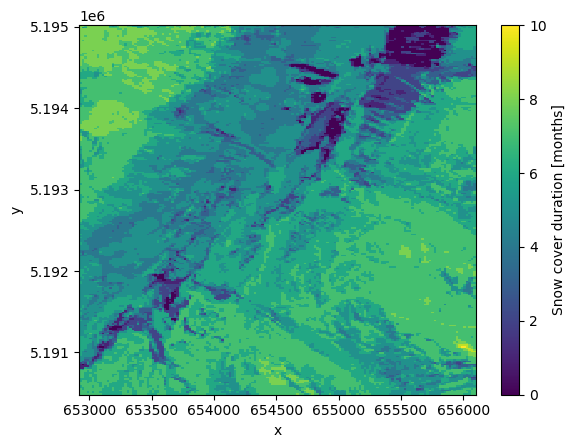

In [19]:
snow.sum(dim='time').plot(cbar_kwargs={'label': 'Snow cover duration [months]'})

## Excercise: Snow cover mapping - Interpretation and sensitivity analysis

*Tasks and questions:*

* The snow cover duration appears to be quite short in some parts of our AOI (given that the village of Obergurgl is located at > 1900 m a.s.l.)? Let's have a look at these areas. Try to get a simple color composite for one date using Google Earth Engine and the tools shown in the tutorial. Maybe this helps with interpretation. Alternatively use (monotemporal) higher resolution data from other sources and display them in Python or in a GIS. What are the surface characteristics of the areas with short snow cover duration? Does this point to potential limitations of the snow classification approach?
* For the binary classification of NDSI into "snow" and "no snow", we had chosen an NDSI threshold of 0.4. What if we change this threshold? How does this affect the classification results? Test a range of thresholds (0.2 to 0.6 with step 0.02), and visualize the effects of varying the threshold on the spatio-temporal classification results.

### RGB composite for interpretation of snow cover duration patterns

Why is the snow cover duration apparently so short in some parts of our AOI? Let's have a look at these areas. Maybe a simple color composite from one date helps with interpretation.

As our downloaded time series contains only the NDSI, we need a new query: We search for the closest image to a certain date matching also some other criteria (bounds, cloud cover percentage).

In [20]:
S2_RGB = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(AOI) \
    .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 10) \
    .closest('2022-08-01') \
    .preprocess() \
    .select(['B4', 'B3', 'B2'])                                                         # Query only certain bands from GEE
S2_RGB_ts = S2_RGB.wx.to_time_series()                                                  # Build wxee time series object (although we expect only one observation)
S2_RGB_ds = S2_RGB_ts.wx.to_xarray(region = AOI, crs='EPSG:25832', scale=10)            # Download to xarray dataset, now with 10 m resolution

Requesting data:   0%|          | 0/2 [00:00<?, ?it/s]

Note that this request has unexpectedly found two images of the same day. The reason is that our AOI is located on a tile overlap and, thus, gets imagery from both tiles. We simply take the mean value along the time dimension and plot this composite image.

In [21]:
S2_RGB_ds['time'].values

array(['2022-08-09T10:27:53.000000000', '2022-08-09T10:28:07.000000000'],
      dtype='datetime64[ns]')

Now plot the RGB bands as a true color composite and try to assess the landcover in the areas with relatively short snow cover durqtion. How could this impact the NDSI values?

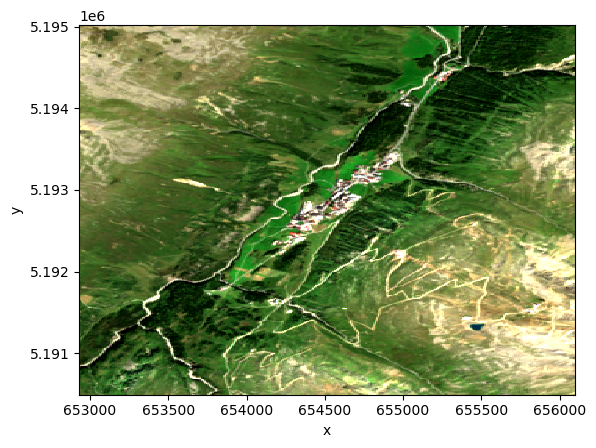

In [22]:
S2_RGB_ds.to_array().mean(dim='time').plot.imshow(robust=True)

### Classification threshold sensitivity analysis

For the binary classification of NDSI into "snow" and "no snow", we had chosen an NDSI threshold of 0.4. What if we change this threshold? How does this affect the classification results?

Let's construct a new dataset `snow_sensitivity` with a new dimension called 'threshold', where we test a range of different values for the threshold parameter (0.2 to 0.6 with step 0.02).

In [23]:
t_var = xr.Variable('threshold', np.arange(0.2, 0.62, 0.02))            # Create a variable for the tresholds
snow_sensitivity = xr.concat([xr.where(S2_ds.NDSI>t, 1, 0) for t in np.arange(0.2, 0.62, 0.02)], dim=t_var)
snow_sensitivity.attrs = S2_ds.attrs                                    # Copy attributes (CRS, spatial resolution, ...)

#### Spatio-temporal sensitivity of snow classification

For each pixel, we compute the average of all the binary snow classification outputs with different thresholds. Assuming that each of these threshold is equally likely to produce a correct classification, we call this average value "snow probability" and plot it in a map for each month. Moreover, we compute the variance of all classification outputs (referring to as "snow classification sensitivity to threshold"). Thereby, we can see where and when the choice of the classification threshold is most critical.

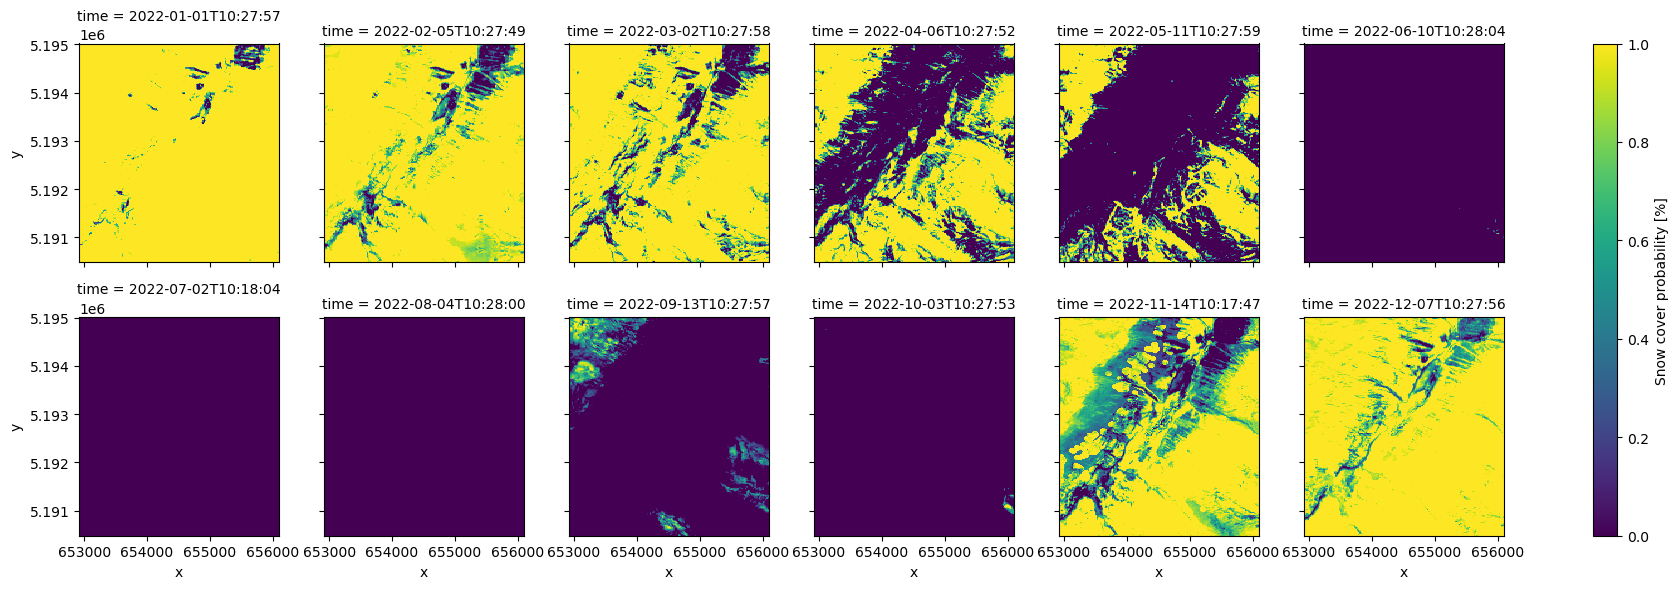

In [24]:
snow_sensitivity.mean(dim='threshold').plot(col='time', col_wrap=6, cbar_kwargs={'label': 'Snow cover probability [%]'})

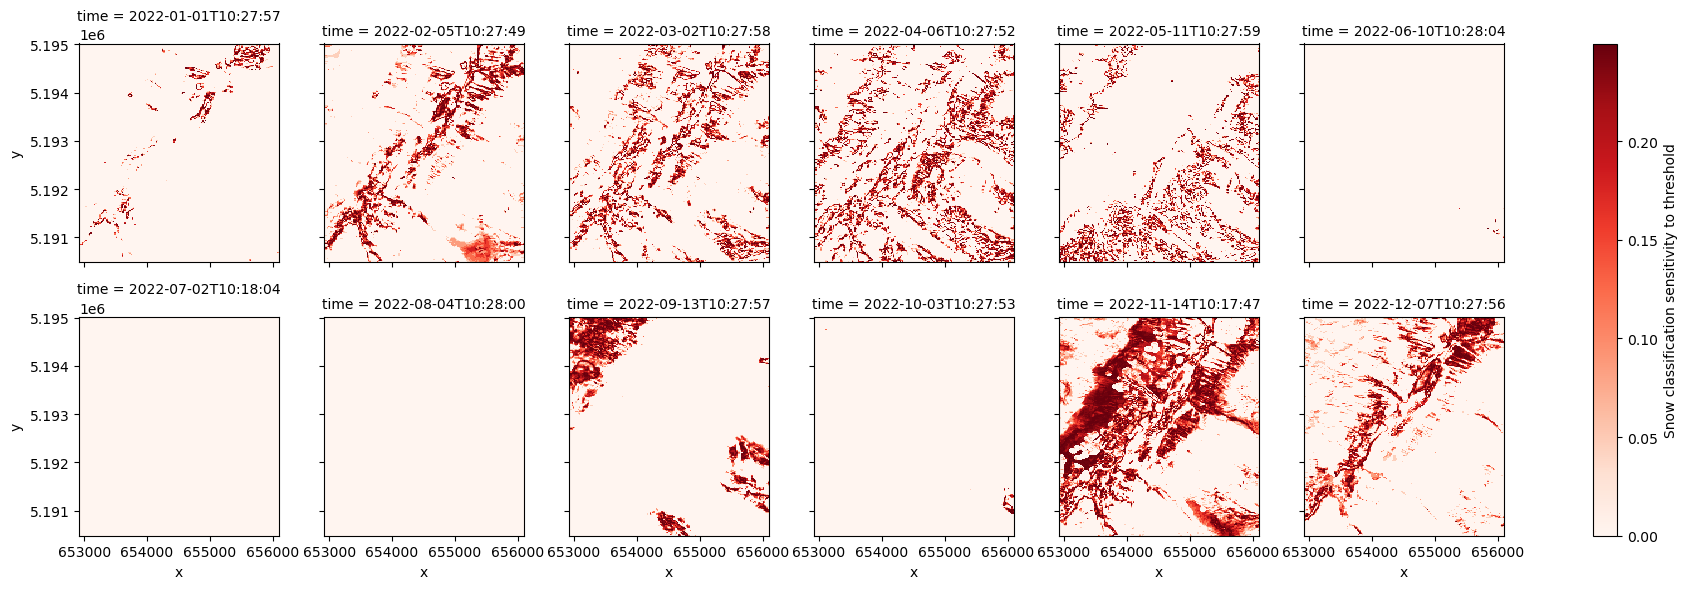

In [37]:
snow_sensitivity.var(dim='threshold').plot(col='time', col_wrap=6, cmap='Reds', cbar_kwargs={'label': 'Snow classification sensitivity to threshold'})

#### Sensitivity of snow covered area to classification threshold

Finally, we want to see how the choice of classification thresholds affects the snow covered area determined over the course of the year.

In [26]:
snow_percentage_sens = np.nanmean(snow_sensitivity.values, axis=(2,3))*100
snow_percentage_sens.shape

(21, 12)

In [27]:
import pandas as pd

df = pd.DataFrame(snow_percentage_sens, index=snow_sensitivity.threshold)               # each month in a separate column, lines indexed with the thresholds
df = df.melt(var_name='Month', value_name='Snow covered area [%]', ignore_index=False)  # melt converts the table to long-form (months are indicated by a column now)
df['Month'] = df['Month']+1                                                             # otherwise the months start with zero
df

,Month,Snow covered area [%]
0.20,1,99.174355
0.22,1,99.063530
0.24,1,98.961017
0.26,1,98.833569
0.28,1,98.706120
...,...,...
0.52,12,89.682210
0.54,12,87.878536
0.56,12,85.384978
0.58,12,82.292965


Plot the mean and the standard deviation (light blue band) for the classifications of each month.

<Axes: xlabel='Month', ylabel='Snow covered area [%]'>

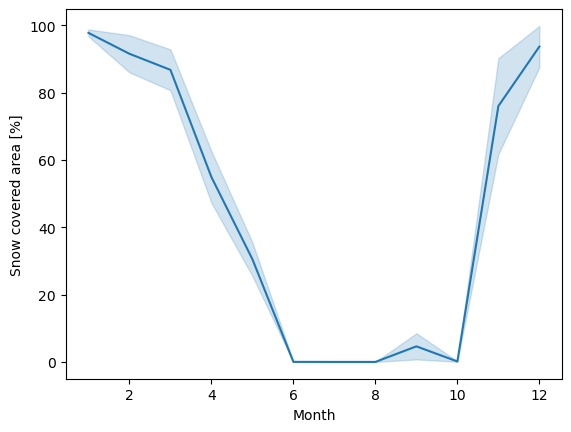

In [28]:
import seaborn as sns
sns.lineplot(data=df, x='Month', y='Snow covered area [%]', errorbar='sd')

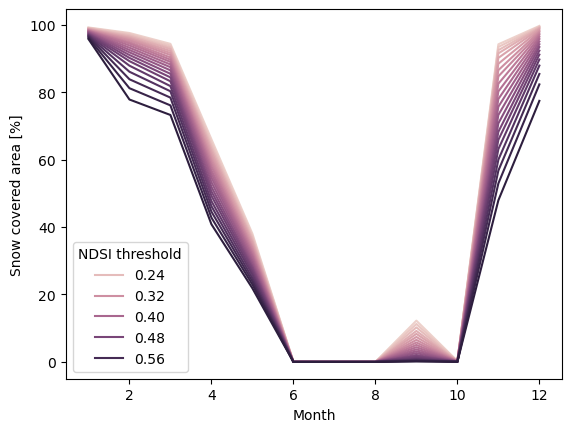

In [38]:
sns.lineplot(data=df, x='Month', y='Snow covered area [%]', hue=df.index)
plt.legend(title='NDSI threshold')

## Conclusions

A simple thresholding approach applied on Sentinel-2 Normalized Difference Snow Index (NDSI) rasters was, in general, shown to be capable of mapping snow cover. Classification of a time series of monthly composites is straightforward and can plausibly track the seasonal evolution of snow covered area.

For some parts of the AOI, the workflow shown in this notebook indicates a short snow cover duration. These areas are mainly covered by forest. This points to difficulties of the approach to map snow cover reliably in forested areas.

The impact of NDSI threshold choice varies with space and time, depending on the snow cover conditions. Completely snow-free or completely snow-covered pixels show sufficient contrast in an NDSI raster and can be classified unambiguously (with a range of thresholds). A patchy snow cover (i) in the melting period and after the first snowfalls in autumn or (ii) in steep and rocky terrain is more ambiguous (mixed pixel problem) and sensitive to the classification threshold.

The approach works without any reference data as long as it is not being validated (no training of a statistical classifier). Note that this example is a binary classification based on only one classification feature which provides a good contrast (i.e. separability) for the target classes. Lots of experience from scientific studies is available on the suitability of the feature (NDSI) and the threshold for the problem at hand. For more complex classification tasks (more classes, poor separability, more features, ...) we need more sophisticated approaches to find appropriate decision boundaries (classification rules), for instance using machine learning.